# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [193]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Import data for equivalence scale and life cycle income profile

In [194]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [195]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'thetab':250,
        'K':9,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 55.1 secs
 t = 2 solved in 47.2 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 63.9 secs
 total stay-time  = 9.4 secs
 total ref-time   = 10.5 secs
 total buy-time   = 8.9 secs
 total rent-time   = 9.6 secs
 full model solved in = 102.4 secs
model simulated in 55.7 secs
numba precompiled in 163.0 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 1.3 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.6 secs
 v_bar and q computed in 1.8 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 2.1 secs
 v_bar and q computed i

### 1.0 Decision Functions

In [197]:
figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [203]:
sol = model_baseline.sol
par = model_baseline.par

print(par.grid_x.round(4))
print(sol.inv_v_buy_fast[0,3].round(4))
print(sol.c_buy_fast[0,3,].round(4))
print(sol.d_prime_buy_fast[0,3,].round(4))
#print(sol.Tda_prime_buy_fast[0,3,].round(2))
print(sol.h_buy_fast[0,3])

[-7.     -5.375  -3.75   -2.125  -0.5     0.      0.0853  0.1998  0.3533
  0.5592  0.8353  1.2057  1.7026  2.369   3.2628  4.4617  6.0697  8.2266
 11.1196 15.    ]
[0.     0.     0.     0.     0.     0.     0.0074 0.0018 0.0067 0.0069
 0.0071 0.0072 0.0073 0.0075 0.0077 0.008  0.0083 0.0087 0.0091 0.0095]
[0.     0.     0.     0.     0.     0.     0.0853 0.0237 0.1772 0.3247
 0.3633 0.3888 0.4175 0.4486 0.5044 0.5678 0.6354 0.7111 0.7921 0.9095]
[0.    0.    0.    0.    0.    0.    0.    1.278 1.278 1.278 1.278 1.278
 1.278 0.    0.    0.    0.    0.    0.    0.   ]
[0.   0.   0.   0.   0.   0.   0.   1.42 1.42 1.42 1.42 1.42 1.42 1.42
 1.42 1.89 2.51 3.34 4.44 4.44]


In [186]:
sim = model_baseline.sim
dp_bool = sim.d_prime>0
hp_bool = sim.h_prime == 0
np.sum(dp_bool*hp_bool)

0

In [204]:
hp0 = sim.h_prime == 0
ht0 = sim.h_tilde == 0
np.sum(hp0*ht0)

63139

### 1.1 Life Cycle Behaviour

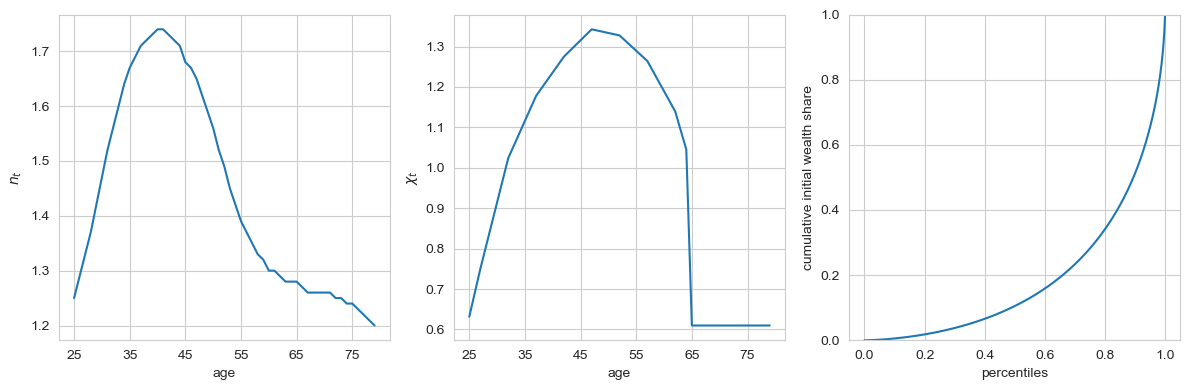

In [108]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

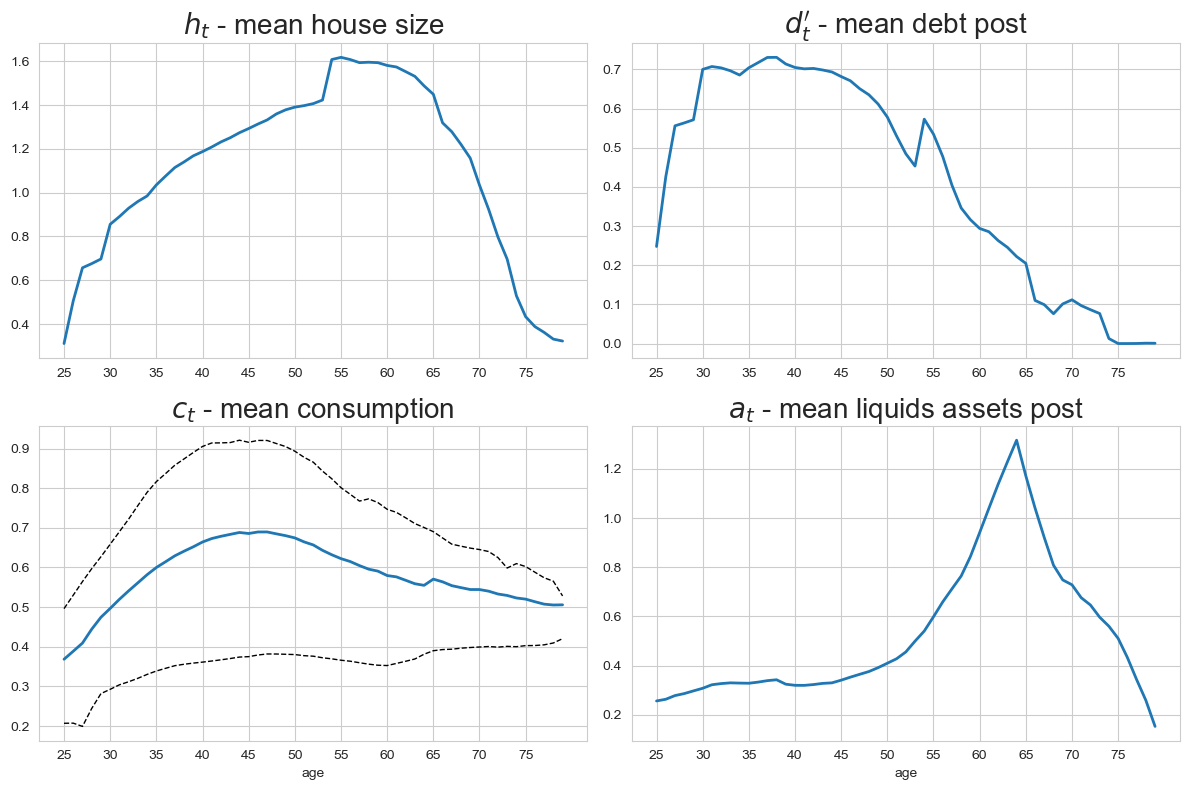

In [128]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Compare with data

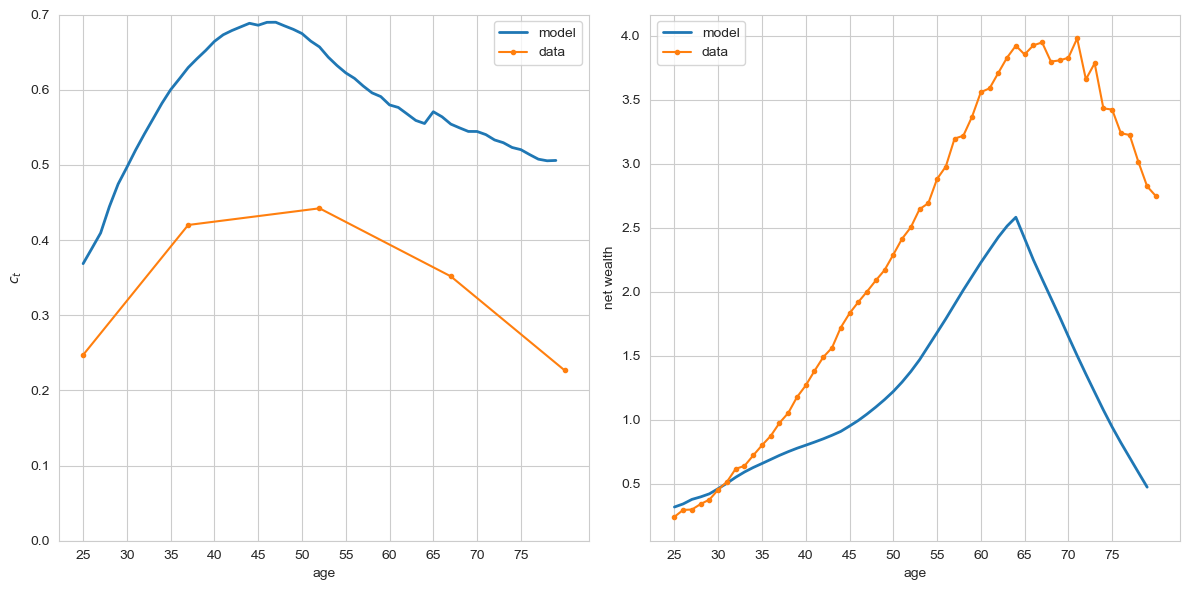

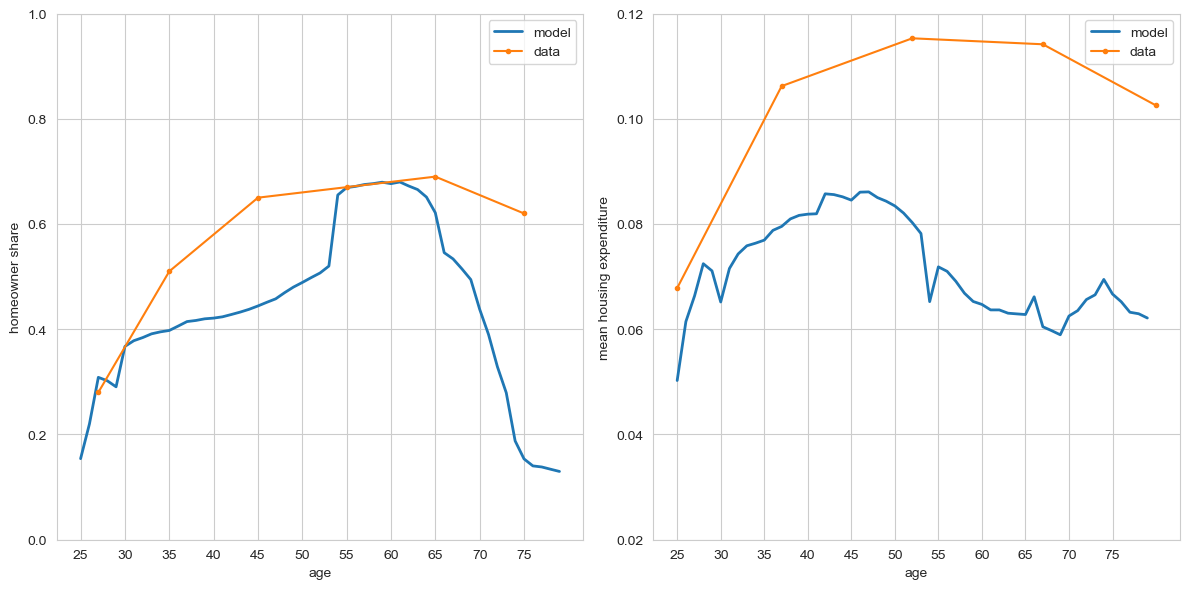

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:370: RuntimeWarning: invalid value encountered in true_divide
  


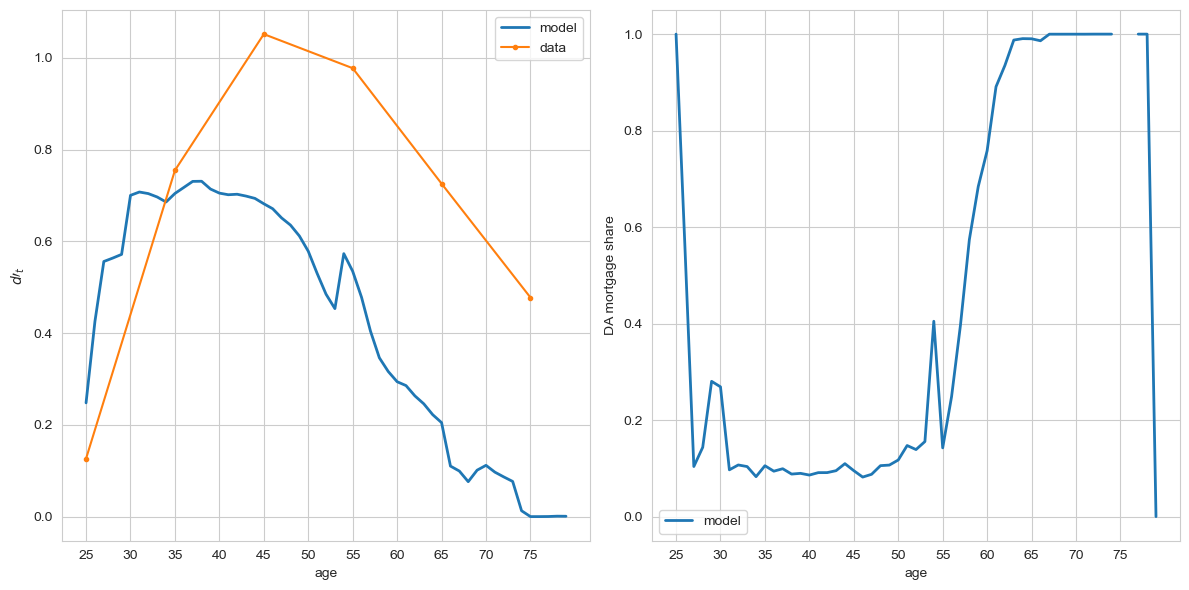

In [136]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

### 1.3 Validate simulation

In [137]:
# unpack
sim = model_baseline.sim 
par = model_baseline.par

# validate consumption decision
I = sim.c < 0

print(f'there are {np.sum(I)} cases of negative consumption') 
if np.sum(I) > 0:
    print(f'ref accounts for {np.sum(I*(sim.discrete==1))} and buy for {np.sum(I*(sim.discrete==2))}.')
    print(f'stay accounts for {np.sum(I*(sim.discrete==0))} and rent for {np.sum(I*(sim.discrete==3))}')
    print(f'the share of negative consumption cases is {np.sum(I)/(par.simN*par.T)}')
    print()
    print('negative simulated consumption occurs in periods:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[0])
    print('and cases per period are:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[1])

there are 0 cases of negative consumption


taxes to labour income is 0.3539
median pre tax income is 0.6097
mean property tax is 0.0106
mean pre tax income is 1.0058


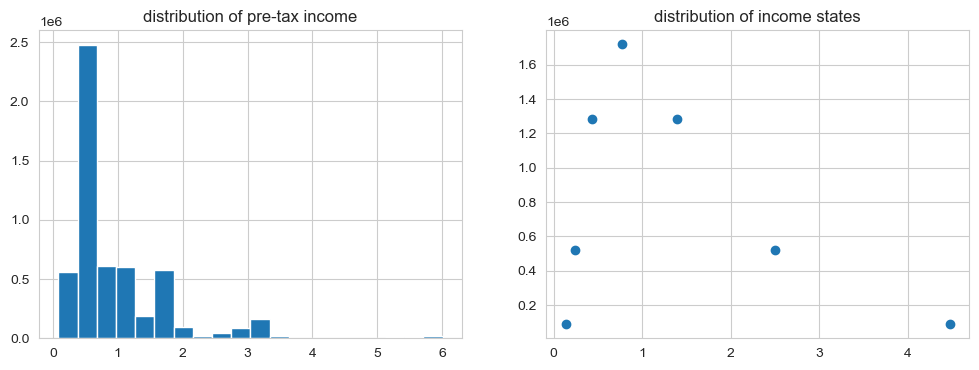

In [138]:
# validate income dynamics and taxation
p = sim.p
y = sim.y
inc_tax = sim.inc_tax
prop_tax = sim.prop_tax
tax_to_inc = np.sum(inc_tax)/np.sum(y)
print(f'taxes to labour income is {tax_to_inc:.4f}')
print(f'median pre tax income is {np.median(y):.4f}')
print(f'mean property tax is {np.mean(prop_tax):.4f}')
print(f'mean pre tax income is {np.mean(y):.4f}')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(y.flatten(),bins=20)
ax1.set_title('distribution of pre-tax income')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(np.unique(p.flatten()),np.unique(p.flatten(),return_counts=True)[1])
ax2.set_title('distribution of income states');


the distribution of house choices is:
[0.   1.42 1.89 2.51 3.34 4.44 5.91]
[3152422  608057  643093  365346  244020  399237   87825]

the distribution of rental choices is:
[0.   1.07 1.42 1.89]
[2410717 2200463  442065  446755]



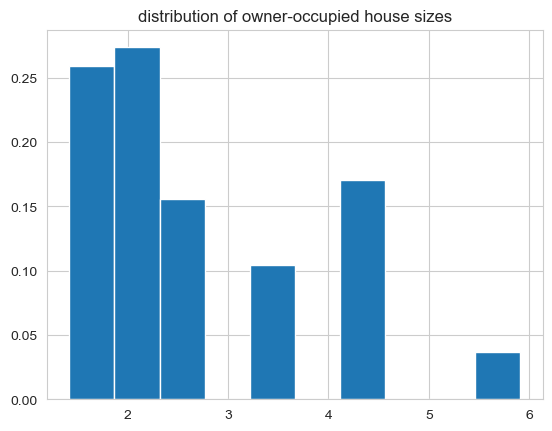

In [131]:
# validate housing and rental decisions
print('the distribution of house choices is:')
print(np.unique(sim.h_prime,return_counts=True)[0])
print(np.unique(sim.h_prime,return_counts=True)[1])
print()
print('the distribution of rental choices is:')
print(np.unique(sim.h_tilde,return_counts=True)[0])
print(np.unique(sim.h_tilde,return_counts=True)[1])
print()
assert np.sum(np.unique(sim.h_tilde,return_counts=True)[1]) == par.simN*par.T, 'rent and own should sum to total number of agents'
assert np.sum(np.unique(sim.h_prime,return_counts=True)[1]) == par.simN*par.T, 'rent and own should sum to total number of agents'

#assert np.unique(sim.h_tilde,return_counts=True)[1][0]+np.unique(sim.h_prime,return_counts=True)[1][0] == par.simN*par.T, f'sum of homeowners and renters is {np.unique(sim.h_tilde,return_counts=True)[1][0]+np.unique(sim.h,return_counts=True)[1][0]} and not equal to total number of agents'

#print(f'mean homeowner share is {np.unique(sim.h_tilde,return_counts=True)[1][0]/(par.T*par.simN):.4f}')
h_bool = sim.h > 0 
h = sim.h[h_bool]
plt.hist(h.flatten(),weights=np.ones_like(h.flatten())/len(h.flatten()))
plt.title('distribution of owner-occupied house sizes');

In [205]:
# check for errors in housing stock
bool_buy = sim.discrete == 2
bool_stay = sim.discrete == 0
bool_ref = sim.discrete == 1
bool_rent = sim.discrete == 3

print(f'number of buyers with zero housing stock is {np.sum(sim.h_prime[bool_buy] == 0)}')
print(f'number of stayers with zero housing stock is {np.sum(sim.h_prime[bool_stay] == 0)}')
print(f'number of refinancers with zero housing stock is {np.sum(sim.h_prime[bool_ref] == 0)}')
print(f'number of renters with positive housing stock is {np.sum(sim.h_prime[bool_rent] > 0)}')
hp0 = sim.h_prime[0]
bb0 = bool_buy[0]
print(f'number of buyers with zero housing stock in t=1 is {np.sum(hp0[bb0]== 0)}')
print(f'number of buyers at t=1 is {np.sum(bb0)}')

number of buyers with zero housing stock is 63139
number of stayers with zero housing stock is 0
number of refinancers with zero housing stock is 0
number of renters with positive housing stock is 0
number of buyers with zero housing stock in t=1 is 1481
number of buyers at t=1 is 15405


In [141]:
import mt
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par

counter = 0
for t in range(par.T):
    counter_t = 0
    for n in range(par.simN):
        if sim.discrete[t,n] != 3 and sim.h_prime[t,n] == 0:
            counter += 1
            counter_t += 1
            print(f'period: {t}')
            print(f'agent: {n}')
    if counter_t > 0:        
        print(f'number of buyers with zero housing stock in period {t} is {counter_t}')
print(f'the total number of buyers with zero housing stock is {counter}')

period: 0
agent: 17
period: 0
agent: 56
period: 0
agent: 61
period: 0
agent: 113
period: 0
agent: 159
period: 0
agent: 417
period: 0
agent: 480
period: 0
agent: 486
period: 0
agent: 495
period: 0
agent: 504
period: 0
agent: 764
period: 0
agent: 807
period: 0
agent: 848
period: 0
agent: 943
period: 0
agent: 947
period: 0
agent: 1083
period: 0
agent: 1110
period: 0
agent: 1151
period: 0
agent: 1182
period: 0
agent: 1220
period: 0
agent: 1473
period: 0
agent: 1611
period: 0
agent: 1677
period: 0
agent: 1682
period: 0
agent: 1910
period: 0
agent: 1939
period: 0
agent: 1971
period: 0
agent: 2005
period: 0
agent: 2014
period: 0
agent: 2076
period: 0
agent: 2147
period: 0
agent: 2334
period: 0
agent: 2385
period: 0
agent: 2400
period: 0
agent: 2443
period: 0
agent: 2446
period: 0
agent: 2516
period: 0
agent: 2565
period: 0
agent: 2696
period: 0
agent: 2931
period: 0
agent: 3007
period: 0
agent: 3053
period: 0
agent: 3115
period: 0
agent: 3244
period: 0
agent: 3368
period: 0
agent: 3378
period

In [149]:
t,n = 0,943
from simulate import find_nearest
from consav import linear_interp
sol = model_baseline.sol

print(f'discrete choice: {sim.discrete[t,n]}')
print(f'housing state: {sim.h[t,n]}')
print(f'housing choice: {sim.h_prime[t,n]}')
print(f'mortgage choice: {sim.d_prime[t,n]}')
print(f'pre-tax income: {sim.y[t,n]}')
m_gross_buy = sim.m[t,n] - sim.d[t,n] + (1-par.delta-par.C_sell)*par.q*sim.h[t,n]-mt.property_tax(par.q,sim.h[t,n],par)
print(f'cash-on-hand: {m_gross_buy}')
print(f'initial assets: {sim.a[t,n]}')
print(f'consumption choice: {sim.c[t,n]}')
print(f'income shock: {sim.i_y[t,n]}')
i_m_buy = find_nearest(par.grid_x,m_gross_buy)

assert par.grid_x[i_m_buy] < m_gross_buy, f'grid_x is {par.grid_x[i_m_buy]} which is smaller than {m_gross_buy}'


discrete choice: 2
housing state: 0.0
housing choice: 0.0
mortgage choice: 0.0
pre-tax income: 0.08535481230057254
cash-on-hand: 0.5552553472006142
initial assets: 0.292128537101244
consumption choice: 0.2631268100993702
income shock: 0


In [152]:
inv_v_rent = 0
for i_ht in range(par.Nhtilde):
        m_net_rent = m_gross_buy - par.q_r*par.grid_htilde[i_ht]
        inv_v_rent_temp = linear_interp.interp_1d(par.grid_m,sol.inv_v_rent[t,i_ht,sim.i_y[t,n]],m_net_rent) 
        if inv_v_rent_temp > inv_v_rent:
            inv_v_rent = inv_v_rent_temp
            i_ht_best = i_ht
            h_tilde_best = par.grid_htilde[i_ht_best]

In [156]:
print(f'value function rent i_m: {inv_v_rent:.6f}')
print(f'value function buy i_m: {sol.inv_v_buy_fast[t,sim.i_y[t,n],i_m_buy]:.6f}')
print(f'housing policy function i_m: {sol.h_buy_fast[t,sim.i_y[t,n],i_m_buy]}')
print(f'mortgage policy function i_m: {sol.d_prime_buy_fast[t,sim.i_y[t,n],i_m_buy]}')
print(f'value function buy i_m+1: {sol.inv_v_buy_fast[t,sim.i_y[t,n],i_m_buy+1]:.6f}')
print(f'housing policy function i_m+1: {sol.h_buy_fast[t,sim.i_y[t,n],i_m_buy+1]}')
print(f'mortgage policy function i_m+1: {sol.d_prime_buy_fast[t,sim.i_y[t,n],i_m_buy+1]}')

value function rent i_m: 0.005643
value function buy i_m: 0.005750
housing policy function i_m: 0.0
mortgage policy function i_m: 0.0
value function buy i_m+1: 0.005781
housing policy function i_m+1: 0.0
mortgage policy function i_m+1: 0.0


In [158]:

print(f'{linear_interp.interp_1d(par.grid_x,sol.inv_v_buy_fast[t,sim.i_y[t,n],:],m_gross_buy):.6f}')

0.005762


In [159]:
print(i_m_buy)
print(m_gross_buy)
print(np.abs(par.grid_x[i_m_buy]-m_gross_buy))
print(np.abs(par.grid_x[i_m_buy+1]-m_gross_buy))

10
0.5552553472006142
0.06775258800674278
0.11039228696863956


In [43]:
# share of buy choices in the model
print(f'the share of buy choices is {np.mean(sim.discrete == 2):.4f}')
print(f'annual share of houses sold is {np.mean(sim.h_prime != sim.h):.4f}')

the share of buy choices is 0.0280
annual share of houses sold is 0.0408


In [44]:
# validate mortage decision
D = sim.d > 0 # take mortgage?
Dp = sim.d_prime > 0
DA = sim.Tda_prime > 0 # choose deferred amortisation?
t_mat = np.outer(np.arange(par.T),np.ones(par.simN))
D_org = Dp*(sim.Td_prime - (par.Td_bar) == t_mat) # boolean for loan originations

print(f'average mortgage size at origination is {np.mean(sim.d_prime[D_org]):.4f}')
print(f'sum of outstanding mortgage balances are {np.sum(sim.d):.4f}')
#print(f'periods where mortgages are issued are {np.where(np.sum(sim.d_prime,axis=1)>0)[0]}')

average mortgage size at origination is 1.9423
sum of outstanding mortgage balances are 1804862.9333


In [45]:
# validate impact of financial regulation
ltv_denom = sim.h_prime[D_org]
ltv_num = sim.d_prime[D_org]
dti_denom = sim.y[D_org]
ltvs = ltv_num/ltv_denom
dtis = ltv_num/dti_denom

print('the distribution of DA periods is:')
print(np.unique(sim.Tda,return_counts=True)[0])
print(np.unique(sim.Tda,return_counts=True)[1])
print(f'and the share of DA mortgages at origination is {np.sum(DA[D_org])/np.sum(Dp[D_org]):.4f}')
print()
print(f'mean LTV is {np.mean(ltvs):.4f} and mean DTI is {np.mean(dtis):.4f} at mortgage origination')

the distribution of DA periods is:
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[5228109   35784   37608   40075   37224   34234   33472   34433   19061]
and the share of DA mortgages at origination is 1.0000

mean LTV is 0.7693 and mean DTI is 1.1406 at mortgage origination


### 1.4 Inspect discrete choices

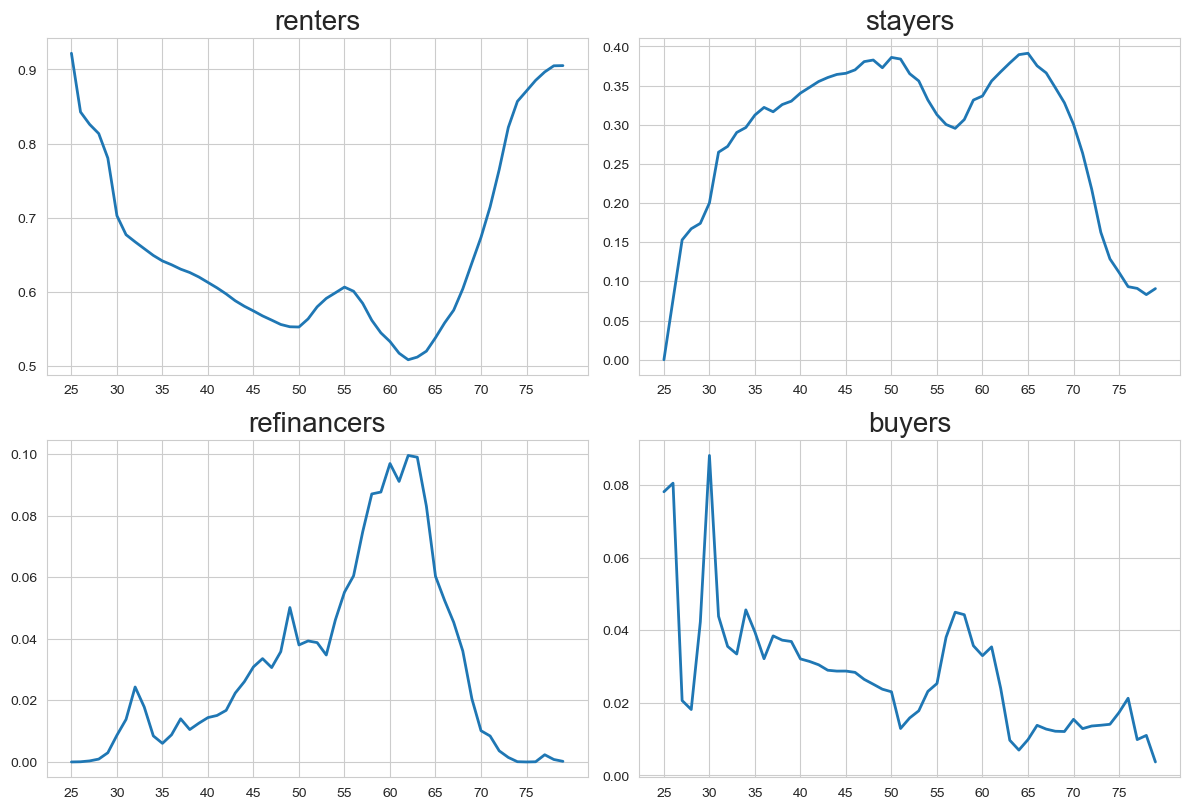

In [46]:
figs.homeownership(model_baseline)

### 1.5 Inspect the life cycle profile of a given household

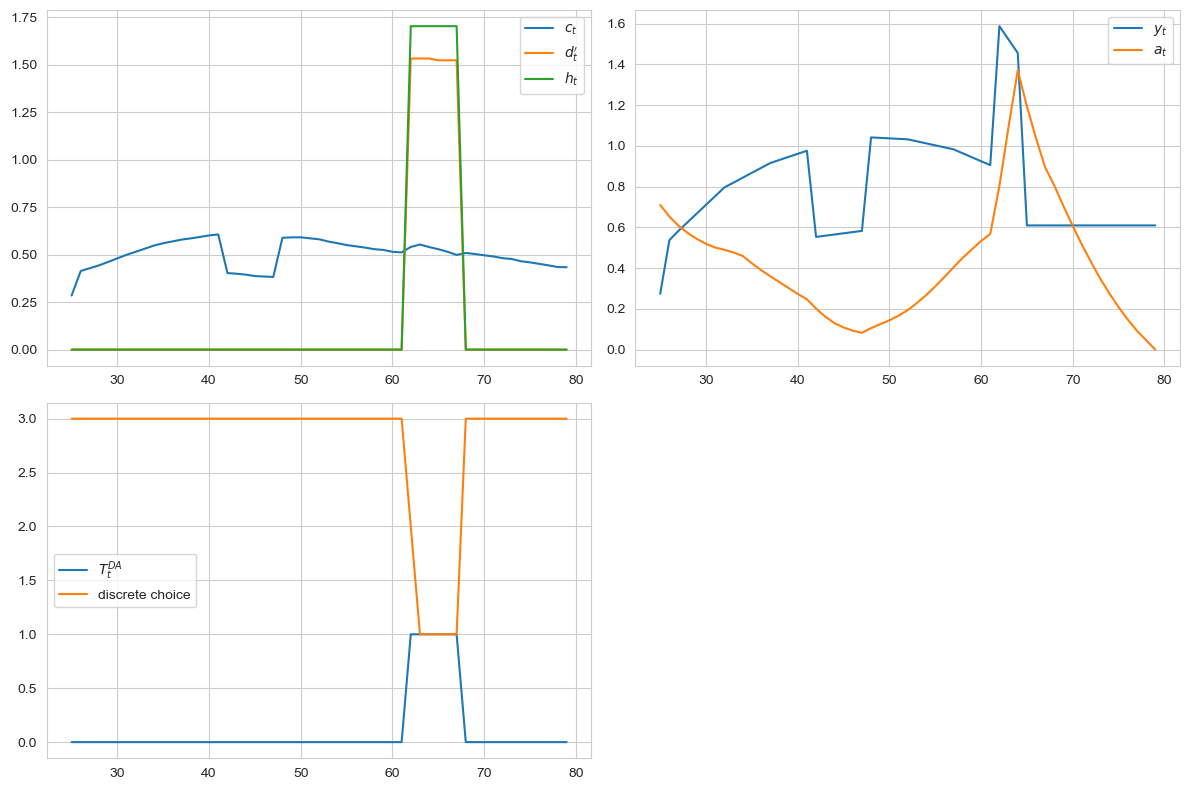

In [26]:
figs.example_household(model_baseline,hh_no=50_000)

### 1.6 Aggregate moments from baseline model

In [47]:
import analyse as ana
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.3439
  Mean house size = 2.8385
  Average housing expenditure = 0.0782
  Mean mortgage size = 1.7133
  Share of homeowners with mortgage = 0.5725
  DA mortgage share = 0.2515
  Average LTV ratio = 0.7006
  Average DTI ratio = 1.0495
  Gini coefficient = 0.7146


In [48]:
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.2271
  Annual fraction of houses sold = 0.0408
  Home ownership rate of <35 y.o. = 0.2457
  Mean NW at age 75 / mean NW at age 55/50 = 0.5164
  Share of households leaving no bequest = 0.6504


## 2 Model without interest rate deduction

In [ ]:
# consumption equiavalent variation
cev = ana.cev(model_baseline)

### Loop to match bequest level with initial wealth

In [49]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 30058.3249
total bequest is 34917.9790
mean bequest is 0.3492
average hh pre-tax income is 673864.9715


In [ ]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')